In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import spacy
import gensim
import nltk
import scipy
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)
from sklearn.model_selection import cross_validate
from sklearn.base import clone as sklearn_clone
from sklearn.model_selection import KFold

from tqdm import tqdm
tqdm.pandas()

import random

import sys
sys.path.append('..')

from helpers.model import (
    balance_data
)

In [2]:
UNDERSAMPLING = True

## Load data

In [3]:
df_styl = pd.read_parquet('../datasets/used_data/02_classical_ml/02_01_benchmark_styllometric_features.parquet')
df_pos = pd.read_parquet('../datasets/used_data/02_classical_ml/02_02_benchmark_POS_ngrams.parquet')
df_ngram = pd.read_parquet('../datasets/used_data/02_classical_ml/02_03_benchmark_words_ngrams.parquet')

In [4]:
print(df_styl.shape, df_pos.shape, df_ngram.shape)

(2394, 30) (2394, 1170) (2394, 1120)


In [5]:
y_train = df_styl['assestment']

In [6]:
df_styl.pop('assestment');
df_pos.pop('assestment');
df_ngram.pop('assestment');

## Make balanced datasets

In [7]:
X_train_u, y_train_u = balance_data(df_styl, y_train, undersampling=UNDERSAMPLING, seed=111)
X_pos_u, _ = balance_data(df_pos, y_train, undersampling=UNDERSAMPLING, seed=111)
X_ngram_u, _ = balance_data(df_ngram, y_train, undersampling=UNDERSAMPLING, seed=111)

In [8]:
words = X_ngram_u['TEXT_WORD'].str.split(' ').values
X_ngram_u.pop('TEXT_WORD');

## CV creation
### LDA

In [9]:
ideal_topic_num = 10

In [10]:
dictionary = gensim.corpora.Dictionary(words)

bow_corpus = [dictionary.doc2bow(doc) for doc in words]


lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = ideal_topic_num, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   random_state=111,
                                   workers = 7)

topics = []

for line in tqdm(words):
    line_bow = dictionary.doc2bow(line)
    doc_lda = lda_model[line_bow]
    
    topics.append( max(doc_lda, key=lambda x:x[1])[0] )

# X_train_u['topic'] = topics

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1282/1282 [00:00<00:00, 6867.24it/s]


In [11]:
x = lda_model.show_topics(num_topics=ideal_topic_num, num_words=5)

for topic,word in x:
    print(topic, word)

0 0.021*"podatek" + 0.018*"energia" + 0.011*"rocznie" + 0.011*"możliwość" + 0.010*"mały"
1 0.029*"procent" + 0.017*"sprawa" + 0.012*"móc" + 0.012*"minister" + 0.012*"mówić"
2 0.024*"sprawiedliwość" + 0.023*"partia" + 0.016*"pis" + 0.012*"praca" + 0.011*"wybory"
3 0.025*"budżet" + 0.017*"program" + 0.016*"sędzia" + 0.016*"państwo" + 0.015*"szkoła"
4 0.014*"swój" + 0.013*"kaczyński" + 0.011*"prawo" + 0.011*"trybunał" + 0.011*"polak"
5 0.017*"the" + 0.015*"przyp" + 0.014*"uchodźca" + 0.013*"badać" + 0.011*"czas"
6 0.048*"europejski" + 0.038*"unia" + 0.016*"komisja" + 0.013*"rząd" + 0.013*"duży"
7 0.025*"miasto" + 0.019*"liczba" + 0.018*"chodzić" + 0.016*"kraków" + 0.013*"rząd"
8 0.033*"kraj" + 0.023*"europa" + 0.021*"polak" + 0.021*"człowiek" + 0.020*"platforma"
9 0.019*"węgiel" + 0.018*"prezydent" + 0.018*"ukraina" + 0.016*"rosja" + 0.012*"europejski"


In [12]:
y_train_u_topics = pd.DataFrame(y_train_u.copy())
y_train_u_topics['topic'] = topics
y_train_u_topics['n'] = 1
y_train_u_topics.groupby(['topic', 'assestment']).sum().reset_index().pivot(index='topic',columns='assestment',values='n')

assestment,0,1
topic,,
0,57,56
1,46,56
2,60,51
3,50,63
4,62,62
5,79,59
6,66,75
7,90,85
8,65,73


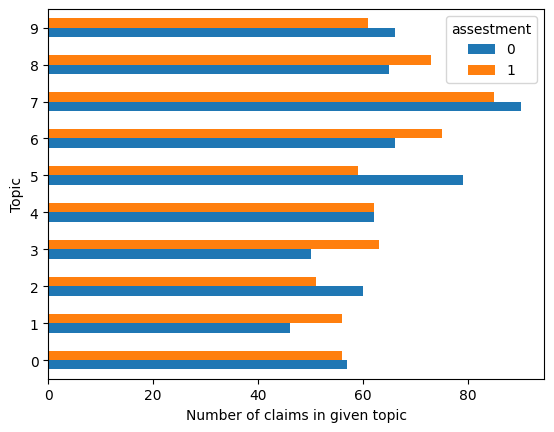

In [25]:
df_plot = y_train_u_topics.groupby(['topic', 'assestment']).sum().reset_index().pivot(index='topic',columns='assestment',values='n')
# df_plot[1] = -df_plot[1]

# Plotting bidirectional bar plot
fig, ax = plt.subplots()
df_plot.plot(kind='barh', stacked=False, ax=ax)

# Adjusting labels and legend
ax.set_ylabel('Topic')
ax.set_xlabel('Number of claims in given topic')
# ax.set_title('Bidirectional Bar Plot')
# ax.legend(title='Assessment', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

### Kfold

In [13]:
cv_fold = []
cv_fold_i = []

for i in y_train_u_topics['topic'].unique().reshape(10,-1):
    train_cv = X_train_u.index[ ~np.isin(y_train_u_topics["topic"], i) ].values
    test_cv = X_train_u.index[ np.isin(y_train_u_topics["topic"], i) ].values
    
    # train_cv_i = X_train_u.reset_index().index[ ~np.isin(X_train_u["topic"], i) ].values
    # test_cv_i = X_train_u.reset_index().index[ np.isin(X_train_u["topic"], i) ].values
    
    cv_fold.append( [train_cv, test_cv])
    # cv_fold_i.append( [train_cv_i, test_cv_i])

In [14]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X_train_u)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(X_train_u):
    train_cv = X_train_u.iloc[ train_index, : ].index.values
    test_cv = X_train_u.iloc[ test_index, : ].index.values

    # train_cv_i= X_train_u.reset_index().iloc[ train_index, : ].index.values
    # test_cv_i = X_train_u.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, test_cv])
    # cv_Kfold_i.append( [train_cv_i, test_cv_i])

## Run experiments

In [16]:
def run_experiment(X, y, cv, clf_org, r_min=0.05):

    results = {
        'test_accuracy' : [],
        'test_precision' : [],
        'test_recall' : [],
        'test_f1' : [],
        'col_keep' : []
    }

    c_matrix = np.zeros((2,2))

    for train_cv, test_cv in cv:
        clf = sklearn_clone(clf_org)
        
        X_train_t = X[X.index.isin(train_cv)]
        y_train_t = y[y.index.isin(train_cv)]

        # keep only columns with corr > 0.05
        if r_min:
            col_keep = []
            for c in X_train_t.columns:
                min_v =X_train_t[c].values.min()
                max_v = X_train_t[c].values.max()
    
                if min_v < max_v:
                    r = scipy.stats.pearsonr(X_train_t[c].values, y_train_t)[0]
                    if ~np.isnan(r) and r > r_min:
                        col_keep.append(c)
            
            if len(col_keep) == 0:
                print('No values returned')
        
            X_train_t = X_train_t[col_keep]
        else:
            col_keep =  X_train_t.columns.values.tolist()


        X_test_t = X[X.index.isin(test_cv)]
        y_test_t = y[y.index.isin(test_cv)]
        
        if r_min:
            X_test_t = X_test_t[col_keep]

        clf.fit(X_train_t, y_train_t)

        y_pred = clf.predict(X_test_t)

        confusion = confusion_matrix(y_test_t, y_pred)
        c_matrix += confusion

    #     TN, FP = confusion[0, 0], confusion[0, 1]
    #     FN, TP = confusion[1, 0], confusion[1, 1]

        results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
        results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
        results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
        results['test_f1'].append( f1_score(y_test_t, y_pred) ) 
        results['col_keep'].append( len(col_keep)) 
    
    metrics = {
        "Accuracy": np.array(results['test_accuracy']),
        "Precision": np.array(results['test_precision']).mean(),
        "Recall": np.array(results['test_recall']).mean(),
        "F1 Score":  np.array(results['test_f1']),
        "Cols used": np.array(results['col_keep']),
        }

#     print(c_matrix)

    return metrics

## Topics Kfold

In [17]:
random.seed(111)

In [18]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')
clf_lr_01 = LogisticRegression(max_iter=5000, C=0.1, penalty='l2', solver='liblinear')
clf_rf = RandomForestClassifier(random_state=111, max_depth=5)

In [22]:
for clf_used, clf_name in zip(
    [
        clf_lr_1, 
        # clf_rf, clf_xgb
    ],[
        'lr C1', 
        # 'rf d5', 'xgb  '
    ]
):
        
    for X_used, x_name, r_min in zip(
        [X_ngram_u, X_ngram_u, X_ngram_u, X_ngram_u, X_train_u, X_pos_u, X_pos_u, X_pos_u, X_pos_u],
        ['ngrams  None', 'ngrams  0.01', 'ngrams  0.03', 'ngrams  0.05', 'features    ', 'pos     None', 'pos     0.01', 'pos     0.03', 'pos     0.05'],
        [None, 0.01, 0.03, 0.05, None, None, 0.01, 0.03, 0.05]
    ):
        out = run_experiment(X_used, y_train_u, cv_fold, clf_used, r_min)
        print(
            x_name, 
            clf_name,
            f'Accuracy {out["Accuracy"].mean():.2f}+-{out["Accuracy"].std():.2f}',
            f'F1 Score {out["F1 Score"].mean():.2f}+-{out["F1 Score"].std():.2f}',
            f'Cols used {out["Cols used"].mean():.2f}+-{out["Cols used"].std():.2f}',
            # f'Cols used {len(out["Cols used"])}',
            # f'\n\tPrecision {out["Precision"].mean():.2f}+-{out["Precision"].std():.2f}',
            # f'\n\tRecall {out["Recall"].mean():.2f}+-{out["Recall"].std():.2f}',
            # f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
        )
        
    print()

ngrams  None lr C1 Accuracy 0.54+-0.04 F1 Score 0.50+-0.06 Cols used 1118.00+-0.00
ngrams  0.01 lr C1 Accuracy 0.53+-0.03 F1 Score 0.44+-0.07 Cols used 412.30+-6.81
ngrams  0.03 lr C1 Accuracy 0.52+-0.04 F1 Score 0.42+-0.08 Cols used 191.30+-6.72
ngrams  0.05 lr C1 Accuracy 0.51+-0.04 F1 Score 0.38+-0.08 Cols used 39.40+-3.64
features     lr C1 Accuracy 0.51+-0.06 F1 Score 0.51+-0.06 Cols used 29.00+-0.00
pos     None lr C1 Accuracy 0.52+-0.04 F1 Score 0.52+-0.05 Cols used 1169.00+-0.00
pos     0.01 lr C1 Accuracy 0.51+-0.04 F1 Score 0.50+-0.05 Cols used 395.40+-11.57
pos     0.03 lr C1 Accuracy 0.51+-0.04 F1 Score 0.48+-0.04 Cols used 155.00+-7.39
pos     0.05 lr C1 Accuracy 0.51+-0.04 F1 Score 0.39+-0.07 Cols used 29.00+-5.25



## Random Kfold

In [23]:
for clf_used, clf_name in zip(
    [
        clf_lr_1, 
        # clf_rf, clf_xgb
    ],[
        'lr C1', 
        # 'rf d5', 'xgb  '
    ]
):
        
    for X_used, x_name, r_min in zip(
       [X_ngram_u, X_ngram_u, X_ngram_u, X_ngram_u, X_train_u, X_pos_u, X_pos_u, X_pos_u, X_pos_u],
        ['ngrams  None', 'ngrams  0.01', 'ngrams  0.03', 'ngrams  0.05', 'features    ', 'pos     None', 'pos     0.01', 'pos     0.03', 'pos     0.05'],
        [None, 0.01, 0.03, 0.05, None, None, 0.01, 0.03, 0.05]
    ):
        out = run_experiment(X_used, y_train_u, cv_Kfold, clf_used, r_min)
        print(
            x_name, 
            clf_name,
            f'Accuracy {out["Accuracy"].mean():.2f}+-{out["Accuracy"].std():.2f}',
            f'F1 Score {out["F1 Score"].mean():.2f}+-{out["F1 Score"].std():.2f}',
            f'Cols used {out["Cols used"].mean():.2f}+-{out["Cols used"].std():.2f}',
            # f'Cols used {len(out["Cols used"])}',
            # f'\n\tPrecision {out["Precision"].mean():.2f}+-{out["Precision"].std():.2f}',
            # f'\n\tRecall {out["Recall"].mean():.2f}+-{out["Recall"].std():.2f}',
            # f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
        )
        
    print()

ngrams  None lr C1 Accuracy 0.55+-0.05 F1 Score 0.53+-0.07 Cols used 1118.00+-0.00
ngrams  0.01 lr C1 Accuracy 0.52+-0.04 F1 Score 0.46+-0.06 Cols used 415.20+-8.13
ngrams  0.03 lr C1 Accuracy 0.52+-0.04 F1 Score 0.45+-0.06 Cols used 194.50+-11.28
ngrams  0.05 lr C1 Accuracy 0.50+-0.05 F1 Score 0.38+-0.05 Cols used 39.50+-4.30
features     lr C1 Accuracy 0.51+-0.04 F1 Score 0.49+-0.04 Cols used 29.00+-0.00
pos     None lr C1 Accuracy 0.52+-0.05 F1 Score 0.52+-0.03 Cols used 1169.00+-0.00
pos     0.01 lr C1 Accuracy 0.51+-0.04 F1 Score 0.50+-0.04 Cols used 395.00+-9.65
pos     0.03 lr C1 Accuracy 0.52+-0.04 F1 Score 0.48+-0.05 Cols used 163.60+-27.93
pos     0.05 lr C1 Accuracy 0.50+-0.04 F1 Score 0.39+-0.06 Cols used 29.50+-3.20

